<a href="https://colab.research.google.com/github/martinpius/PYTORCH/blob/main/BackPropGeneralized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from timeit import default_timer as timer
t1 = timer()
try:
  from google.colab import drive
  drive.mount("/content/drive/", force_remount = True)
  import torch, random, math
  import torch.nn.functional as F
  from tqdm.auto import tqdm
  import matplotlib.pyplot as plt
  print(f">>>> You are in CoLaB with torch version: {torch.__version__}")
except Exception as e:
  print(f">>>> {type(e)}: {e}\n>>>> Please correct {type(e)} and reload")

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f">>>> Available device: {device}")
BATCH_SIZE = 128 if device == torch.device("cuda") else 64
def mytimer(t: float = timer())->float:
  h = int(t / (60 * 60))
  m = int(t % (60 * 60) / 60)
  s = int(t % 60)
  return f"hrs: {h:04}, mins: {m:>02}, secs: {s:>5.2f}"
print(f">>>> Time elapsed: \t{mytimer(timer() - t1)}")

Mounted at /content/drive/
>>>> You are in CoLaB with torch version: 2.0.1+cu118
>>>> Available device: cpu
>>>> Time elapsed: 	hrs: 0000, mins: 00, secs: 43.00


In [2]:
file_path = "/content/drive/MyDrive/Language models/makemore-master/names.txt"
names  = open(file_path, "r").read().splitlines()
print(f">>>> The dataset has a toatal of {len(names):,} unique names\
\n>>>> The length of the shortest name is {min(len(name) for name in names)} characters\
\n>>>> The longest name has {max(len(name) for name in names)} characters\
\n>>>> The first 10 names in the dataset are:\n {names[:10]}")

>>>> The dataset has a toatal of 32,033 unique names
>>>> The length of the shortest name is 2 characters
>>>> The longest name has 15 characters
>>>> The first 10 names in the dataset are:
 ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']


In [3]:
chars = sorted(list(set("".join(names))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}
print(f">>>> Total unique characters in the dataset is: {len(chars)}\
\n>>>> The unique list of characters is:\n {chars}\
\n>>>> The character to index lookup dictionary is : \n {stoi}\
\n>>>> The index to character lookup dictionary is: \n {itos}")

>>>> Total unique characters in the dataset is: 26
>>>> The unique list of characters is:
 ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
>>>> The character to index lookup dictionary is : 
 {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
>>>> The index to character lookup dictionary is: 
 {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [4]:
def backpropDataset(names_list):
  
  X, Y = [], []
  block_size = 4

  for name in names_list:

    context = [0] * block_size
    for char in name + ".":
      idx = stoi[char]
      X.append(context)
      Y.append(idx)
      context = context[1:] + [idx]
  
  X, Y = torch.tensor(X), torch.tensor(Y)
  return X, Y



In [5]:
random.seed(1920)
random.shuffle(names)
n1, n2 = int(0.8 * len(names)), int(0.9 * len(names))

X_tr, Y_tr = backpropDataset(names[:n1])
X_val, Y_val = backpropDataset(names[n1:n2])
X_ts, Y_ts = backpropDataset(names[n2:])
print(f">>>> X_tr shape: {X_tr.shape}, Y_tr shape: {Y_tr.shape}\
\n>>>> X_val shape: {X_val.shape}, Y_val shape: {Y_val.shape}\
\n>>>> X_ts shape: {X_ts.shape} Y_ts shape: {Y_ts.shape}")

>>>> X_tr shape: torch.Size([182507, 4]), Y_tr shape: torch.Size([182507])
>>>> X_val shape: torch.Size([22843, 4]), Y_val shape: torch.Size([22843])
>>>> X_ts shape: torch.Size([22796, 4]) Y_ts shape: torch.Size([22796])


In [6]:
input_dim, output_dim = len(stoi), len(itos)
emb_dim, h_dim = 10, 200
block_size = 4
g = torch.Generator().manual_seed(12190)
C = torch.randn(size = (input_dim, emb_dim), generator = g)
W1 = torch.randn(size = (block_size * emb_dim, h_dim), generator = g) * (5/3) * (block_size * emb_dim)**-0.5
b1 = torch.randn(h_dim, generator = g) * 0.1
W2 = torch.randn(size = (h_dim, output_dim), generator = g)*0.1
b2 = torch.randn(output_dim, generator = g) * 0.1
bn_gain = torch.randn(size = (1, h_dim), generator = g) * 0.1 + 1
bn_bias = torch.randn(size = (1, h_dim))* 0.1

parameters = [C, W1, W2, b1, b2, bn_gain, bn_bias]
print(f">>>> Total number of learnable parameters is : {sum(p.numel() for p in parameters):,}")
for p in parameters:
  p.requires_grad = True

>>>> Total number of learnable parameters is : 14,297


In [7]:
# Selecting a single batch for Testing:
ix = torch.randint(low = 0, high = len(X_tr), size = (BATCH_SIZE,))
xbatch, ybatch = X_tr[ix], Y_tr[ix]
n = BATCH_SIZE

In [8]:
def grads_checker(s, grad, auto_grad):
  ex = torch.all(grad == auto_grad.grad).item()
  app = torch.allclose(grad, auto_grad.grad)
  max_diff = (grad - auto_grad.grad).abs().max().item()
  print(f">>>> {s:.5s}| exactly: {str(ex):5s} | approximately: {str(app):5s}, maximum difference: {max_diff}")

In [9]:
# Step by step back-prop
EMB = C[xbatch] # get the embedding layer
EMB_cat = EMB.view(BATCH_SIZE, -1) # Flatten Layer
h_prebn = EMB_cat @ W1 + b1
bn_meani = 1 / n * h_prebn.sum(dim = 0, keepdims = True) # mean over the batch
bn_diff = h_prebn - bn_meani # deviation from the mean
bn_diff2 = bn_diff ** 2 # squared distance from the mean
bn_var = 1 / (n-1) * bn_diff2.sum(dim = 0, keepdims = True)
bn_varinv = bn_var ** -0.5
bn_raw = bn_diff * bn_varinv
h_preact = bn_raw * bn_gain + bn_bias
h = torch.tanh(h_preact)
logits = h @ W2 + b2
logits_maxes = logits.max(dim = 1, keepdims = True).values
logits_norm = logits - logits_maxes
counts = logits_norm.exp()
counts_sum = counts.sum(dim = 1, keepdims = True)
counts_suminv = counts_sum ** -1
probs = counts * counts_suminv
logprobs = probs.log()
loss = -logprobs[torch.arange(n), ybatch].mean()

for p in parameters:
  p.grad = None

for t in [logprobs, probs, counts, counts_suminv, counts_sum,
          logits, logits_maxes, logits_norm, h, W2, b2,
          h_preact, bn_raw, bn_diff, bn_var, bn_varinv,
          bn_diff2, h_prebn, bn_meani, W1, b1, EMB, EMB_cat]:
          t.retain_grad()
# Pytorch autograd
loss.backward()
loss




tensor(3.5592, grad_fn=<NegBackward0>)

In [33]:
# hard-grads in action:
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[torch.arange(n), ybatch] = -(1.0 / n)
dprobs = 1.0 / probs * dlogprobs
dcounts = counts_suminv * dprobs
dcounts_suminv = (counts * dprobs).sum(dim = 1, keepdims = True)
dcounts_sum = (-1.0 * counts_sum ** -2) * dcounts_suminv
dcounts += torch.ones_like(counts) * dcounts_sum
dlogits_norm = logits_norm.exp() * dcounts
dlogits = torch.ones_like(logits) * dlogits_norm
dlogits_maxes = (-1.0 * torch.ones_like(logits) * dlogits_norm).sum(dim = 1, keepdims = True)
dlogits += F.one_hot(logits.max(dim = 1).indices, num_classes = logits.shape[1]) * dlogits_maxes
dw2 = h.T @ dlogits
dh = dlogits @ W2.T
db2 = dlogits.sum(dim = 0)
dh_preact = (1 - h**2) * dh
dbn_raw = bn_gain * dh_preact
dbn_gain = (bn_raw * dh_preact).sum(dim = 0, keepdims = True)
dbn_bias = dh_preact.sum(dim = 0, keepdims = True)
dbn_diff = bn_varinv * dbn_raw
dbn_varinv = (bn_diff * dbn_raw).sum(dim = 0, keepdims = True)
dbn_var = (-0.5 * bn_var ** -1.5) * dbn_varinv
dbn_diff2 = (1 / (n - 1)) * torch.ones_like(bn_diff2) * dbn_var
dbn_diff += 2 * bn_diff * dbn_diff2
dh_prebn = 1.0 * torch.ones_like(h_prebn) * dbn_diff
dbn_meani = (-1.0 * torch.ones_like(bn_meani) * dbn_diff).sum(dim = 0, keepdims = True)
dh_prebn += 1/n * torch.ones_like(h_prebn) * dbn_meani
db1 = dh_prebn.sum(dim = 0)
dw1 = EMB_cat.T @ dh_prebn
dEMB_cat = dh_prebn @ W1.T
dEMB = dEMB_cat.clone().view(EMB.shape)

dC = torch.zeros_like(C)
for k in range(xbatch.shape[0]):
  for j in range(xbatch.shape[1]):
    ix = xbatch[k, j]
    dC[ix] += dEMB[k,j]


In [34]:
grads_checker("dlogprobs", dlogprobs, logprobs)
grads_checker("dprobs", dprobs, probs)
grads_checker("dcounts", dcounts, counts)
grads_checker("dcounts_suminv", dcounts_suminv, counts_suminv)
grads_checker("dcounts_sum", dcounts_sum, counts_sum)
grads_checker("dlogits_norm", dlogits_norm, logits_norm)
grads_checker("dlogits", dlogits, logits)
grads_checker("dlogits_maxes", dlogits_maxes, logits_maxes)
grads_checker("dw2", dw2, W2)
grads_checker("db2", db2, b2)
grads_checker("dh", dh, h)
grads_checker("dh_preact", dh_preact, h_preact)
grads_checker("dbn_raw", dbn_raw, bn_raw)
grads_checker("dbn_gain", dbn_gain, bn_gain)
grads_checker("dbn_bias", dbn_bias, bn_bias)
grads_checker("dbn_diff", dbn_diff, bn_diff)
grads_checker("dbn_varinv", dbn_varinv, bn_varinv)
grads_checker("dbn_var", dbn_var, bn_var)
grads_checker("dbn_diff2", dbn_diff2, bn_diff2)
grads_checker("dh_prebn", dh_prebn, h_prebn)
grads_checker("dbn_meani", dbn_meani, bn_meani)
grads_checker("db1", db1, b1)
grads_checker("dw1", dw1, W1)
grads_checker("dEMB_cat", dEMB_cat, EMB_cat)
grads_checker("dEMB", dEMB, EMB)
grads_checker("dC", dC, C)


>>>> dlogp| exactly: True  | approximately: True , maximum difference: 0.0
>>>> dprob| exactly: True  | approximately: True , maximum difference: 0.0
>>>> dcoun| exactly: True  | approximately: True , maximum difference: 0.0
>>>> dcoun| exactly: True  | approximately: True , maximum difference: 0.0
>>>> dcoun| exactly: True  | approximately: True , maximum difference: 0.0
>>>> dlogi| exactly: True  | approximately: True , maximum difference: 0.0
>>>> dlogi| exactly: True  | approximately: True , maximum difference: 0.0
>>>> dlogi| exactly: True  | approximately: True , maximum difference: 0.0
>>>> dw2| exactly: True  | approximately: True , maximum difference: 0.0
>>>> db2| exactly: True  | approximately: True , maximum difference: 0.0
>>>> dh| exactly: True  | approximately: True , maximum difference: 0.0
>>>> dh_pr| exactly: False | approximately: True , maximum difference: 4.656612873077393e-10
>>>> dbn_r| exactly: False | approximately: True , maximum difference: 4.656612873077393e

In [35]:
losses = []
steps = []
EPOCHES = 100000

In [36]:
# Training the network via our own back-prop:
for epoch in tqdm(range(EPOCHES)):
  ix = torch.randint(low = 0, high = len(X_tr), size = (BATCH_SIZE,))
  xbatch, ybatch = X_tr[ix], Y_tr[ix]

  # Forward pass
  # Step by step back-prop
  EMB = C[xbatch] # get the embedding layer
  EMB_cat = EMB.view(BATCH_SIZE, -1) # Flatten Layer
  h_prebn = EMB_cat @ W1 + b1
  bn_meani = 1 / n * h_prebn.sum(dim = 0, keepdims = True) # mean over the batch
  bn_diff = h_prebn - bn_meani # deviation from the mean
  bn_diff2 = bn_diff ** 2 # squared distance from the mean
  bn_var = 1 / (n-1) * bn_diff2.sum(dim = 0, keepdims = True)
  bn_varinv = bn_var ** -0.5
  bn_raw = bn_diff * bn_varinv
  h_preact = bn_raw * bn_gain + bn_bias
  h = torch.tanh(h_preact)
  logits = h @ W2 + b2
  logits_maxes = logits.max(dim = 1, keepdims = True).values
  logits_norm = logits - logits_maxes
  counts = logits_norm.exp()
  counts_sum = counts.sum(dim = 1, keepdims = True)
  counts_suminv = counts_sum ** -1
  probs = counts * counts_suminv
  logprobs = probs.log()
  loss = -logprobs[torch.arange(n), ybatch].mean()

  for p in parameters:
    p.grad = None

  # for t in [logprobs, probs, counts, counts_suminv, counts_sum,
  #           logits, logits_maxes, logits_norm, h, W2, b2,
  #           h_preact, bn_raw, bn_diff, bn_var, bn_varinv,
  #           bn_diff2, h_prebn, bn_meani, W1, b1, EMB, EMB_cat]:
  #           t.retain_grad()
  # # Pytorch autograd
  # loss.backward()
  # loss

  # hard-grads in action:
  dlogprobs = torch.zeros_like(logprobs)
  dlogprobs[torch.arange(n), ybatch] = -(1.0 / n)
  dprobs = 1.0 / probs * dlogprobs
  dcounts = counts_suminv * dprobs
  dcounts_suminv = (counts * dprobs).sum(dim = 1, keepdims = True)
  dcounts_sum = (-1.0 * counts_sum ** -2) * dcounts_suminv
  dcounts += torch.ones_like(counts) * dcounts_sum
  dlogits_norm = logits_norm.exp() * dcounts
  dlogits = torch.ones_like(logits) * dlogits_norm
  dlogits_maxes = (-1.0 * torch.ones_like(logits) * dlogits_norm).sum(dim = 1, keepdims = True)
  dlogits += F.one_hot(logits.max(dim = 1).indices, num_classes = logits.shape[1]) * dlogits_maxes
  dw2 = h.T @ dlogits
  dh = dlogits @ W2.T
  db2 = dlogits.sum(dim = 0)
  dh_preact = (1 - h**2) * dh
  dbn_raw = bn_gain * dh_preact
  dbn_gain = (bn_raw * dh_preact).sum(dim = 0, keepdims = True)
  dbn_bias = dh_preact.sum(dim = 0, keepdims = True)
  dbn_diff = bn_varinv * dbn_raw
  dbn_varinv = (bn_diff * dbn_raw).sum(dim = 0, keepdims = True)
  dbn_var = (-0.5 * bn_var ** -1.5) * dbn_varinv
  dbn_diff2 = (1 / (n - 1)) * torch.ones_like(bn_diff2) * dbn_var
  dbn_diff += 2 * bn_diff * dbn_diff2
  dh_prebn = 1.0 * torch.ones_like(h_prebn) * dbn_diff
  dbn_meani = (-1.0 * torch.ones_like(bn_meani) * dbn_diff).sum(dim = 0, keepdims = True)
  dh_prebn += 1/n * torch.ones_like(h_prebn) * dbn_meani
  db1 = dh_prebn.sum(dim = 0)
  dw1 = EMB_cat.T @ dh_prebn
  dEMB_cat = dh_prebn @ W1.T
  dEMB = dEMB_cat.clone().view(EMB.shape)

  dC = torch.zeros_like(C)
  for k in range(xbatch.shape[0]):
    for j in range(xbatch.shape[1]):
      ix = xbatch[k, j]
      dC[ix] += dEMB[k,j]

  # packing the grads
  grads = [dC, dw1, dw2, db1, db2, dbn_gain, dbn_bias]

  # optimization with LR decaying of 10%
  LR = 0.1 if epoch < 60000 else 0.01
  for p, grad in zip(parameters, grads):
    p.data += -LR * grad

  if epoch % 1000 == 0:
    print(f">>>> Epoch: {epoch + 1 if epoch == 0 else epoch}: Train Loss: {loss.item():.4f}")
  losses.append(loss.item())
  steps.append(epoch)

  0%|          | 0/100000 [00:00<?, ?it/s]

>>>> Epoch: 1: Train Loss: 3.5571
>>>> Epoch: 1000: Train Loss: 2.4242
>>>> Epoch: 2000: Train Loss: 2.2365
>>>> Epoch: 3000: Train Loss: 2.3555
>>>> Epoch: 4000: Train Loss: 2.4022
>>>> Epoch: 5000: Train Loss: 2.2103
>>>> Epoch: 6000: Train Loss: 2.0471
>>>> Epoch: 7000: Train Loss: 2.2278
>>>> Epoch: 8000: Train Loss: 2.1677
>>>> Epoch: 9000: Train Loss: 2.1677
>>>> Epoch: 10000: Train Loss: 2.0961
>>>> Epoch: 11000: Train Loss: 2.1581
>>>> Epoch: 12000: Train Loss: 2.4246
>>>> Epoch: 13000: Train Loss: 2.3672
>>>> Epoch: 14000: Train Loss: 2.2103
>>>> Epoch: 15000: Train Loss: 2.2140
>>>> Epoch: 16000: Train Loss: 2.3844
>>>> Epoch: 17000: Train Loss: 2.1711
>>>> Epoch: 18000: Train Loss: 2.1329
>>>> Epoch: 19000: Train Loss: 2.2465
>>>> Epoch: 20000: Train Loss: 2.2563
>>>> Epoch: 21000: Train Loss: 2.3143
>>>> Epoch: 22000: Train Loss: 1.9779
>>>> Epoch: 23000: Train Loss: 1.9562
>>>> Epoch: 24000: Train Loss: 2.1728
>>>> Epoch: 25000: Train Loss: 1.7600
>>>> Epoch: 26000: Train 

Text(0.5, 1.0, 'Smoothed Training Loss Trajectory')

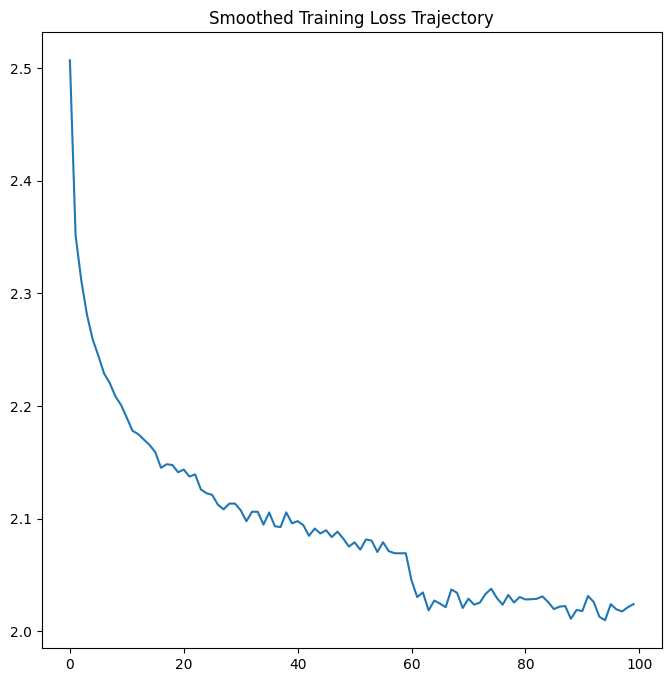

In [37]:
loss_smooth = torch.tensor(losses).view(-1, 1000).mean(dim = 1)
plt.figure(figsize = (8,8))
plt.plot(loss_smooth)
plt.title("Smoothed Training Loss Trajectory")